# Import librairies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [2]:
data = pd.read_csv('df_rio_interpolado.csv')

In [3]:
data.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [4]:
scaler = MinMaxScaler()

In [5]:
# Ajustar o scaler e transformar os dados na coluna TEMP
scaled_data = scaler.fit_transform(data[['TEMP']])

In [6]:
# Salvar o scaler para uso posterior (por exemplo, para reverter a padronização)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [7]:
# Verificar os dados padronizados
print(data.head())

    TEMP
0  27.73
1  27.97
2  25.70
3  26.49
4  22.42


## Train test split

In [8]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [9]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [10]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [11]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [12]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = scaled_data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [13]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [ ]:
epochs_mlp = 30
batch = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp.summary()

In [ ]:
history_mlp = model_mlp.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

### Implementacao e Ajuste do Modelo MLP com regularização

In [ ]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp_reg.summary()

In [ ]:
history_mlp_reg = model_mlp_reg.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

### Implementacao e ajuste do modelo MLP com Dropout

In [ ]:
model_mlp_dropout = Sequential()
model_mlp_dropout.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_dropout.add(Dropout(0.5))  # 50% de dropout
model_mlp_dropout.add(Dense(32, activation='relu'))
model_mlp_dropout.add(Dropout(0.5))  # 50% de dropout
model_mlp_dropout.add(Dense(1))  # Saída
model_mlp_dropout.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp_dropout.summary()



In [ ]:
history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [ ]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.2))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.2))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train, 
                                              Y_train, 
                                              validation_data=(X_valid, Y_valid), 
                                              epochs=epochs_mlp, 
                                              batch_size=32, 
                                              verbose=1)


## Comparando os 4 modelos

In [ ]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
    accuracy = 100 - mape  # Interpretação da acurácia como "100 - MAPE"
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"Acurácia: {accuracy:.2f}%")
    
    return mae, mse, rmse, mape, accuracy

# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard, acc_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg, acc_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout, acc_dropout = evaluate_model(model_mlp_dropout, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop, acc_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

# Comparação dos resultados (opcional)
print("\nComparação de resultados:")
print(f"Modelo Padrão - MAE: {mae_standard:.4f}, RMSE: {rmse_standard:.4f}, MAPE: {mape_standard:.4f}%, Acurácia: {acc_standard:.2f}%")
print(f"Modelo com Regularização - MAE: {mae_reg:.4f}, RMSE: {rmse_reg:.4f}, MAPE: {mape_reg:.4f}%, Acurácia: {acc_reg:.2f}%")
print(f"Modelo com Dropout - MAE: {mae_dropout:.4f}, RMSE: {rmse_dropout:.4f}, MAPE: {mape_dropout:.4f}%, Acurácia: {acc_dropout:.2f}%")
print(f"Modelo com Regularização e Dropout - MAE: {mae_reg_drop:.4f}, RMSE: {rmse_reg_drop:.4f}, MAPE: {mape_reg_drop:.4f}%, Acurácia: {acc_reg_drop:.2f}%")


In [ ]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_mlp.history['loss'], label='Treinamento')
plt.plot(history_mlp.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_mlp_reg.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_mlp_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_mlp_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_dropout.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

In [ ]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Pre-processamento dos Dados

In [14]:
#Hiperparametros
epochs_cnn = 30
batch = 32
lr = 0.001
#adam = optimizers.Adam(lr)


In [15]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (334, 60, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


## Implementando e Ajustando Modelo CNN

In [16]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn.summary()

In [17]:
history_cnn = model_cnn.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs_cnn, 
                            verbose=2)

Epoch 1/30
11/11 - 1s - 136ms/step - loss: 0.0832 - val_loss: 0.0300
Epoch 2/30
11/11 - 0s - 8ms/step - loss: 0.0278 - val_loss: 0.0234
Epoch 3/30
11/11 - 0s - 8ms/step - loss: 0.0165 - val_loss: 0.0103
Epoch 4/30
11/11 - 0s - 8ms/step - loss: 0.0145 - val_loss: 0.0117
Epoch 5/30
11/11 - 0s - 8ms/step - loss: 0.0140 - val_loss: 0.0105
Epoch 6/30
11/11 - 0s - 8ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 7/30
11/11 - 0s - 8ms/step - loss: 0.0131 - val_loss: 0.0096
Epoch 8/30
11/11 - 0s - 8ms/step - loss: 0.0128 - val_loss: 0.0090
Epoch 9/30
11/11 - 0s - 8ms/step - loss: 0.0124 - val_loss: 0.0085
Epoch 10/30
11/11 - 0s - 8ms/step - loss: 0.0122 - val_loss: 0.0081
Epoch 11/30
11/11 - 0s - 8ms/step - loss: 0.0119 - val_loss: 0.0077
Epoch 12/30
11/11 - 0s - 8ms/step - loss: 0.0116 - val_loss: 0.0075
Epoch 13/30
11/11 - 0s - 8ms/step - loss: 0.0113 - val_loss: 0.0072
Epoch 14/30
11/11 - 0s - 8ms/step - loss: 0.0110 - val_loss: 0.0069
Epoch 15/30
11/11 - 0s - 8ms/step - loss: 0.0108 - val_

## Implementando e Ajustando Modelo CNN com Regularização L2

In [18]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_reg.summary()


In [19]:
history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs_cnn, 
                            verbose=2)

Epoch 1/30
11/11 - 2s - 144ms/step - loss: 0.9153 - val_loss: 0.7024
Epoch 2/30
11/11 - 0s - 8ms/step - loss: 0.5979 - val_loss: 0.4732
Epoch 3/30
11/11 - 0s - 9ms/step - loss: 0.4079 - val_loss: 0.3281
Epoch 4/30
11/11 - 0s - 10ms/step - loss: 0.2889 - val_loss: 0.2374
Epoch 5/30
11/11 - 0s - 8ms/step - loss: 0.2158 - val_loss: 0.1829
Epoch 6/30
11/11 - 0s - 8ms/step - loss: 0.1700 - val_loss: 0.1471
Epoch 7/30
11/11 - 0s - 8ms/step - loss: 0.1394 - val_loss: 0.1216
Epoch 8/30
11/11 - 0s - 8ms/step - loss: 0.1166 - val_loss: 0.1024
Epoch 9/30
11/11 - 0s - 8ms/step - loss: 0.0994 - val_loss: 0.0876
Epoch 10/30
11/11 - 0s - 8ms/step - loss: 0.0857 - val_loss: 0.0755
Epoch 11/30
11/11 - 0s - 9ms/step - loss: 0.0747 - val_loss: 0.0656
Epoch 12/30
11/11 - 0s - 13ms/step - loss: 0.0657 - val_loss: 0.0578
Epoch 13/30
11/11 - 0s - 28ms/step - loss: 0.0583 - val_loss: 0.0511
Epoch 14/30
11/11 - 0s - 10ms/step - loss: 0.0522 - val_loss: 0.0458
Epoch 15/30
11/11 - 0s - 13ms/step - loss: 0.0471 -

## Implementando e Ajustando Modelo CNN com Dropout

In [20]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada de pooling
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada densa
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_drop.summary()

In [21]:
history_cnn_drop = model_cnn_drop.fit(X_train_series, Y_train, 
                                       validation_data=(X_valid_series, Y_valid), 
                                       epochs=epochs_cnn, 
                                       verbose=2)


Epoch 1/30
11/11 - 2s - 171ms/step - loss: 0.1246 - val_loss: 0.0771
Epoch 2/30
11/11 - 0s - 11ms/step - loss: 0.0548 - val_loss: 0.0174
Epoch 3/30
11/11 - 0s - 8ms/step - loss: 0.0413 - val_loss: 0.0167
Epoch 4/30
11/11 - 0s - 11ms/step - loss: 0.0412 - val_loss: 0.0165
Epoch 5/30
11/11 - 0s - 10ms/step - loss: 0.0328 - val_loss: 0.0121
Epoch 6/30
11/11 - 0s - 8ms/step - loss: 0.0354 - val_loss: 0.0123
Epoch 7/30
11/11 - 0s - 8ms/step - loss: 0.0304 - val_loss: 0.0118
Epoch 8/30
11/11 - 0s - 8ms/step - loss: 0.0362 - val_loss: 0.0170
Epoch 9/30
11/11 - 0s - 8ms/step - loss: 0.0343 - val_loss: 0.0127
Epoch 10/30
11/11 - 0s - 9ms/step - loss: 0.0329 - val_loss: 0.0108
Epoch 11/30
11/11 - 0s - 8ms/step - loss: 0.0286 - val_loss: 0.0122
Epoch 12/30
11/11 - 0s - 9ms/step - loss: 0.0254 - val_loss: 0.0120
Epoch 13/30
11/11 - 0s - 8ms/step - loss: 0.0294 - val_loss: 0.0094
Epoch 14/30
11/11 - 0s - 8ms/step - loss: 0.0308 - val_loss: 0.0135
Epoch 15/30
11/11 - 0s - 9ms/step - loss: 0.0286 - v

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [22]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.5))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.5))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_reg_drop.summary()

In [23]:
history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, Y_train, 
                                             validation_data=(X_valid_series, Y_valid), 
                                             epochs=epochs_cnn, 
                                             verbose=2)


Epoch 1/30
11/11 - 2s - 155ms/step - loss: 0.9956 - val_loss: 0.7148
Epoch 2/30
11/11 - 0s - 9ms/step - loss: 0.6319 - val_loss: 0.4764
Epoch 3/30
11/11 - 0s - 9ms/step - loss: 0.4346 - val_loss: 0.3362
Epoch 4/30
11/11 - 0s - 8ms/step - loss: 0.3178 - val_loss: 0.2460
Epoch 5/30
11/11 - 0s - 9ms/step - loss: 0.2402 - val_loss: 0.1936
Epoch 6/30
11/11 - 0s - 9ms/step - loss: 0.1973 - val_loss: 0.1584
Epoch 7/30
11/11 - 0s - 9ms/step - loss: 0.1671 - val_loss: 0.1334
Epoch 8/30
11/11 - 0s - 9ms/step - loss: 0.1458 - val_loss: 0.1138
Epoch 9/30
11/11 - 0s - 9ms/step - loss: 0.1236 - val_loss: 0.0983
Epoch 10/30
11/11 - 0s - 9ms/step - loss: 0.1093 - val_loss: 0.0857
Epoch 11/30
11/11 - 0s - 9ms/step - loss: 0.0976 - val_loss: 0.0761
Epoch 12/30
11/11 - 0s - 9ms/step - loss: 0.0855 - val_loss: 0.0668
Epoch 13/30
11/11 - 0s - 9ms/step - loss: 0.0816 - val_loss: 0.0593
Epoch 14/30
11/11 - 0s - 9ms/step - loss: 0.0735 - val_loss: 0.0539
Epoch 15/30
11/11 - 0s - 8ms/step - loss: 0.0640 - val_

## Comparando os 4 Modelos

In [24]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002A854352D40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [25]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo Simples": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn),
        "MSE": mean_squared_error(Y_test, y_pred_cnn),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn)
    },
    "Modelo com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_reg),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_reg),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_reg)
    },
    "Modelo com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_drop)
    },
    "Modelo com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_reg_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_reg_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_reg_drop)
    }
}

# Adicionar a acurácia com base no MAPE
for model, values in metrics.items():
    values["Acurácia"] = 100 - values["MAPE"]  # Calcula a acurácia como 100 - MAPE

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}, Acurácia={values['Acurácia']:.2f}%")


Modelo Simples: MAPE=19.08%, MSE=0.0104, RMSE=0.1019, Acurácia=80.92%
Modelo com Regularização: MAPE=17.95%, MSE=0.0091, RMSE=0.0955, Acurácia=82.05%
Modelo com Dropout: MAPE=17.70%, MSE=0.0091, RMSE=0.0956, Acurácia=82.30%
Modelo com Regularização e Dropout: MAPE=18.43%, MSE=0.0097, RMSE=0.0985, Acurácia=81.57%


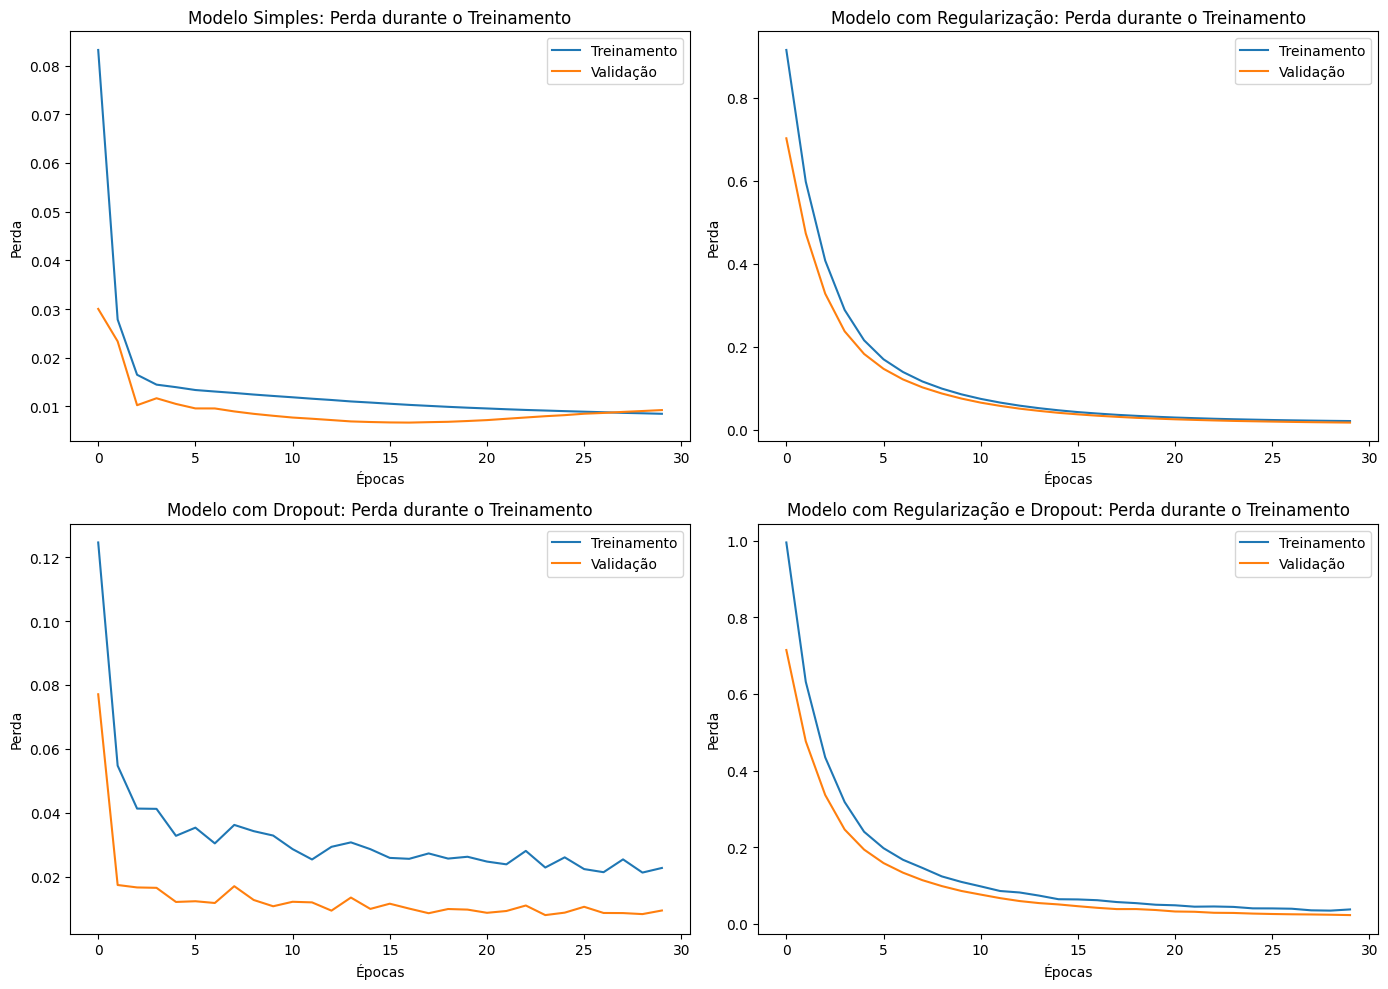

In [26]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['loss'], label='Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


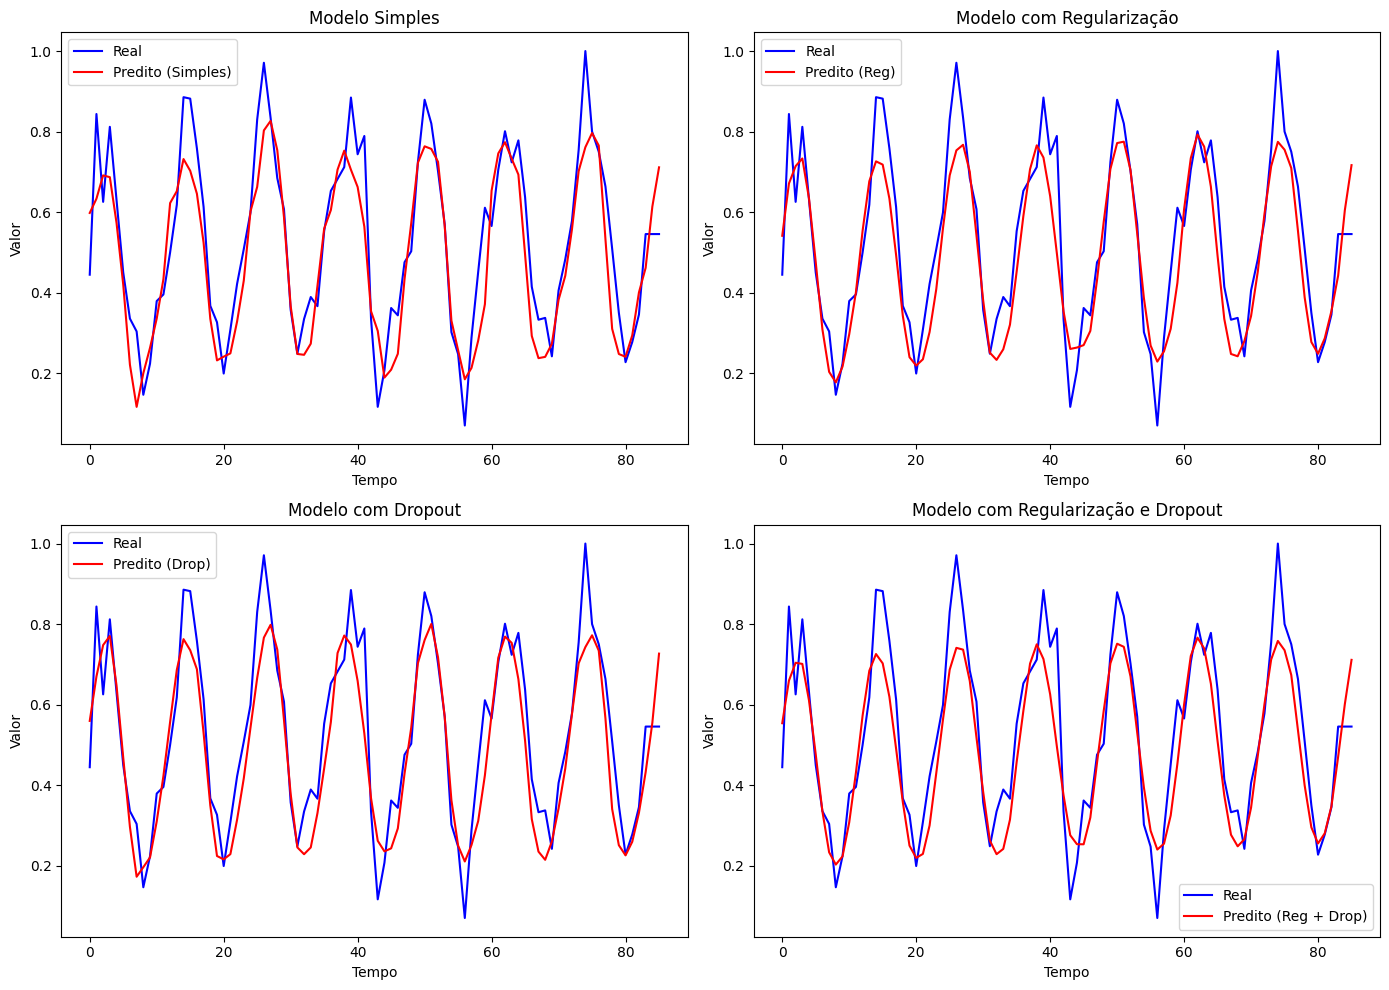

In [27]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


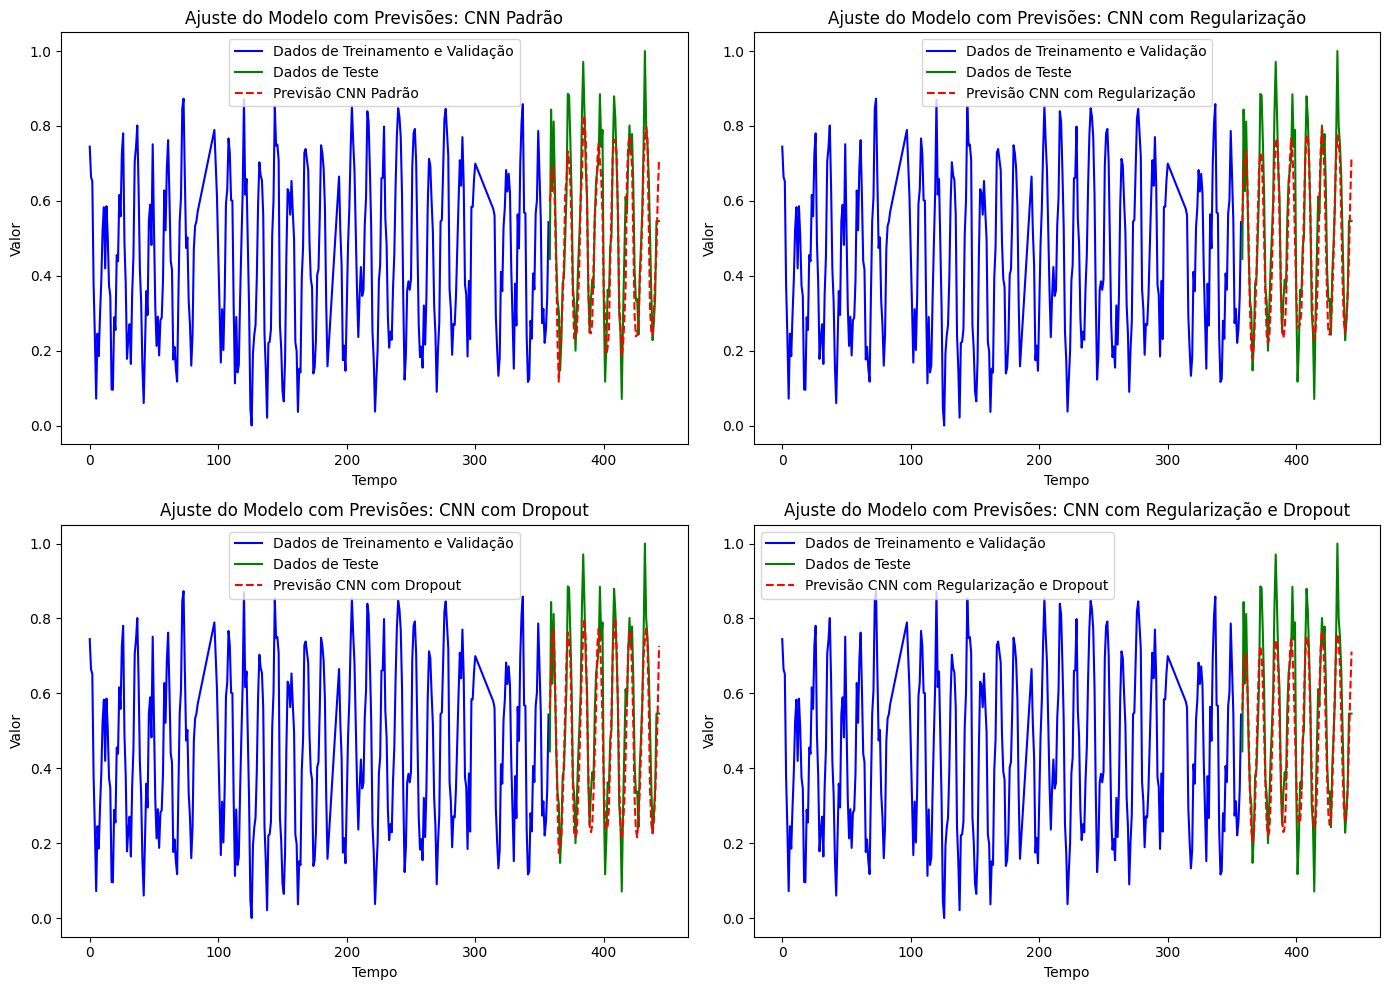

In [28]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [29]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Defina o comprimento da sequência
seq_length = 30  # Ajuste de acordo com sua necessidade
X_train, y_train = create_sequences(scaled_data, seq_length)


## Implementacao e Ajustei do Modelo Padrao

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam())
#model_lstm.summary()

In [ ]:
history_lstm = model_lstm.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid_series, Y_valid), 
                              epochs=15,
                                verbose=2)

## Implementacao e Ajuste do Modelo com Regularizacao L2

In [ ]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer='adam', loss='mse')
#model_lstm_reg.summary()


In [ ]:
# Treinamento do modelo com regularização L2
history_lstm_reg = model_lstm_reg.fit(X_train_series, 
                                      y_train, 
                                      epochs=50, 
                                      batch_size=32, 
                                      validation_split=0.2, 
                                      verbose=1)

## Implementacao e Ajuste do Modelo com Dropout

In [ ]:
model_lstm_dropout = Sequential()
model_lstm_dropout.add(LSTM(64, activation='tanh', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_dropout.add(Dropout(0.2))  # Dropout de 20%
model_lstm_dropout.add(Dense(1))
model_lstm_dropout.compile(optimizer='adam', loss='mse')
#model_lstm_dropout.summary()


In [ ]:
# Treinamento do modelo com Dropout
history_lstm_dropout = model_lstm_dropout.fit(X_train_series, 
                                              y_train, 
                                              epochs=50, 
                                              batch_size=32, 
                                              validation_split=0.2, 
                                              verbose=1)


## Implementacao e Ajuste do modelo com Regularizacao e Dropout

In [ ]:
model_lstm_reg_dropout = Sequential()
model_lstm_reg_dropout.add(
    LSTM(
        50, 
        activation='tanh', 
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_dropout.add(Dropout(0.2))  # Dropout de 20%
model_lstm_reg_dropout.add(Dense(1))
model_lstm_reg_dropout.compile(loss='mse', optimizer='adam')
#model_lstm_reg_dropout.summary()


In [ ]:
history_lstm_reg_dropout = model_lstm_reg_dropout.fit(
    X_train_series, 
    y_train, 
    epochs=50,  # Use o mesmo número de épocas dos outros modelos
    batch_size=32, 
    validation_split=0.2
)

## Comparativo entre os modelos - Predicao e Validacao

In [ ]:
# Lista dos históricos e títulos dos modelos
histories = [history_lstm, history_lstm_reg, history_lstm_dropout, history_lstm_reg_dropout]
titles = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Criando a figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Facilita iterar sobre os eixos

# Plotando cada modelo
for i, history in enumerate(histories):
    axes[i].plot(history.history['loss'], label='Treino', color='blue')
    axes[i].plot(history.history['val_loss'], label='Validação', color='orange')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Épocas')
    axes[i].set_ylabel('MSE')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Obtendo as previsões dos quatro modelos
pred_lstm = model_lstm.predict(X_test_series)
pred_lstm_reg = model_lstm_reg.predict(X_test_series)
pred_lstm_dropout = model_lstm_dropout.predict(X_test_series)
pred_lstm_reg_dropout = model_lstm_reg_dropout.predict(X_test_series)

# Títulos para cada gráfico
titles = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Criando a figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()  # Facilita a iteração sobre os eixos

# Plotando cada modelo
for i, (pred, title) in enumerate(zip([pred_lstm, pred_lstm_reg, pred_lstm_dropout, pred_lstm_reg_dropout], titles)):
    axes[i].plot(Y_test, label='Valores Reais', color='black', linewidth=2)
    axes[i].plot(pred, label='Previsão', linestyle='--', color='blue')
    axes[i].set_title(title)
    axes[i].set_xlabel('Amostra')
    axes[i].set_ylabel('Valor Predito')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Função para calcular as métricas
def evaluate_model(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mape, rmse, mae, r2

# Lista de previsões e nomes dos modelos
predictions = [pred_lstm, pred_lstm_reg, pred_lstm_dropout, pred_lstm_reg_dropout]
model_names = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Calculando as métricas para cada modelo
results = {}
for name, pred in zip(model_names, predictions):
    results[name] = evaluate_model(Y_test, pred)

# Exibindo os resultados
for name, (mape, rmse, mae, r2) in results.items():
    print(f"{name}:")
    print(f"  MAPE: {mape:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("\n")


# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Defina o comprimento da sequência
seq_length = 30  # Ajuste de acordo com sua necessidade
X_train, y_train = create_sequences(scaled_data, seq_length)

# Agora vamos reorganizar os dados para a rede CNN-LSTM
subsequences = 2  # Número de subsequências
timesteps = X_train.shape[1] // subsequences  # Tamanho de cada subsequência
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))

# Repetir para o conjunto de validação
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))

print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)


## Implementacao e ajuste do modelo padrao

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam())

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, 
                                      Y_train, 
                                      validation_data=(X_valid_series_sub, Y_valid), 
                                      epochs=epochs, 
                                      verbose=2)

## Implementacao e Ajuste do modelo com Regularizacao

In [ ]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


## Implementacao e Ajuste do Modelo com Dropout

In [ ]:
model_cnn_lstm_dropout = Sequential()
model_cnn_lstm_dropout.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_dropout.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_dropout.add(TimeDistributed(Flatten()))
model_cnn_lstm_dropout.add(Dropout(0.2))
model_cnn_lstm_dropout.add(LSTM(50, activation='relu'))
model_cnn_lstm_dropout.add(Dropout(0.2))
model_cnn_lstm_dropout.add(Dense(1))
model_cnn_lstm_dropout.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_dropout = model_cnn_lstm_dropout.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [ ]:
model_cnn_lstm_reg_dropout = Sequential()
model_cnn_lstm_reg_dropout.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_dropout.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_dropout.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_dropout.add(Dropout(0.2))
model_cnn_lstm_reg_dropout.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_dropout.add(Dropout(0.2))
model_cnn_lstm_reg_dropout.add(Dense(1))
model_cnn_lstm_reg_dropout.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg_dropout = model_cnn_lstm_reg_dropout.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


## Comparativo entre os modelos

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular MAPE, RMSE e MAE
def calculate_metrics(y_true, y_pred):
    # Calculando o MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calculando o RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Calculando o MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    return mape, rmse, mae

# Realizando as previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series)
y_pred_cnn_lstm_dropout = model_cnn_lstm_dropout.predict(X_test_series)
y_pred_cnn_lstm_reg_dropout = model_cnn_lstm_reg_dropout.predict(X_test_series)

# Calculando as métricas para cada modelo
mape_cnn_lstm, rmse_cnn_lstm, mae_cnn_lstm = calculate_metrics(Y_test, y_pred_cnn_lstm)
mape_cnn_lstm_reg, rmse_cnn_lstm_reg, mae_cnn_lstm_reg = calculate_metrics(Y_test, y_pred_cnn_lstm_reg)
mape_cnn_lstm_dropout, rmse_cnn_lstm_dropout, mae_cnn_lstm_dropout = calculate_metrics(Y_test, y_pred_cnn_lstm_dropout)
mape_cnn_lstm_reg_dropout, rmse_cnn_lstm_reg_dropout, mae_cnn_lstm_reg_dropout = calculate_metrics(Y_test, y_pred_cnn_lstm_reg_dropout)

# Exibindo os resultados
print(f"Modelo CNN-LSTM:")
print(f"MAPE: {mape_cnn_lstm:.4f}, RMSE: {rmse_cnn_lstm:.4f}, MAE: {mae_cnn_lstm:.4f}\n")

print(f"Modelo CNN-LSTM com Regularização:")
print(f"MAPE: {mape_cnn_lstm_reg:.4f}, RMSE: {rmse_cnn_lstm_reg:.4f}, MAE: {mae_cnn_lstm_reg:.4f}\n")

print(f"Modelo CNN-LSTM com Dropout:")
print(f"MAPE: {mape_cnn_lstm_dropout:.4f}, RMSE: {rmse_cnn_lstm_dropout:.4f}, MAE: {mae_cnn_lstm_dropout:.4f}\n")

print(f"Modelo CNN-LSTM com Regularização e Dropout:")
print(f"MAPE: {mape_cnn_lstm_reg_dropout:.4f}, RMSE: {rmse_cnn_lstm_reg_dropout:.4f}, MAE: {mae_cnn_lstm_reg_dropout:.4f}")
